### Detect patterns in Heatmaps regarding the accuracy of prediction
This notebook identifies Head_IDs that are either predicted correct most of the time, incorrect most of the time, or neither of both.
Goal is to identify whether specific pattern can be found when a face is choosen os the odd one out correctly (or the other way round).

In [ ]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from zennit.composites import EpsilonAlpha2Beta1Flat
from functools import partial
from facesim3d.modeling.VGG.vgg_predict import prepare_data_for_human_judgment_model
from facesim3d.modeling.VGG.models import (
    load_trained_vgg_face_human_judgment_model,
    VGGFaceHumanjudgmentFrozenCoreWithLegs,
)
from facesim3d.lrp_functions import Gradient2, feed_attr_output_fn, get_orig_dataset, load_model_for_LRP
import pandas as pd
from facesim3d import local_paths

In [4]:
# Setup
DEVICE = str(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 1. Human Judgement Model

### 1.1. Use existing LOG-File from odd-one-out heatmaps

In [ ]:
csv_folder_hum = local_path.DIR_AVERAGE_HEATMAPS_HUM
csv_path_hum = os.path.join(csv_folder_hum, "run_log_efficient_average_triplet_heatmaps_VGGFaceHumanJudgment.csv")

In [9]:
df_hum = pd.read_csv(csv_path_hum, sep=",")
df_hum.head()

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps
0,1,1190,1190,target_met,551,639
1,2,1190,1190,target_met,959,231
2,3,1190,1190,target_met,613,577
3,4,1190,1190,target_met,604,586
4,5,1190,1190,target_met,781,409


In [10]:
# correct the number of correct heatmaps with the number of evaluated heatmaps
df_hum["accuracy"] = df_hum["correct_heatmaps"] / df_hum["collected_heatmaps"]
df_hum.head()

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps,accuracy
0,1,1190,1190,target_met,551,639,0.463025
1,2,1190,1190,target_met,959,231,0.805882
2,3,1190,1190,target_met,613,577,0.515126
3,4,1190,1190,target_met,604,586,0.507563
4,5,1190,1190,target_met,781,409,0.656303


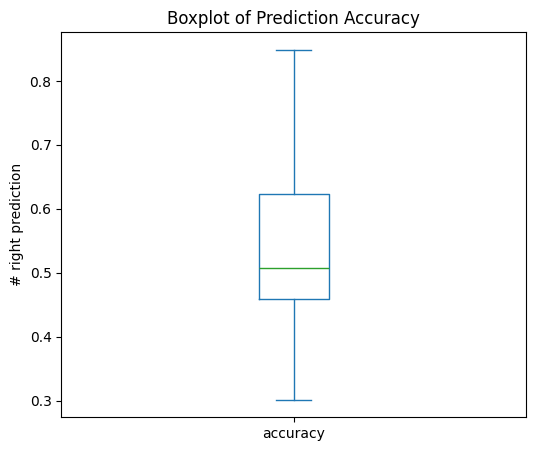

In [11]:
df_hum["accuracy"].plot(kind='box', figsize=(6, 5))
plt.title("Boxplot of Prediction Accuracy")
plt.ylabel("# right prediction")
plt.show()

In [12]:
df_hum["correct_heatmaps"].describe()

count     100.000000
mean      650.590000
std       149.249036
min       359.000000
25%       546.000000
50%       604.000000
75%       742.250000
max      1010.000000
Name: correct_heatmaps, dtype: float64

#### -> on average, heatmaps were 650/1190 times predicted accurately 

## Best predicted Heads

In [8]:
# Sort descending:
top_heads = df_hum.sort_values(by="correct_heatmaps", ascending=False).head(3)
top_heads

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps,accuracy
21,22,1190,1190,target_met,1010,180,0.848739
94,95,1190,1190,target_met,1001,189,0.841176
5,6,1190,1190,target_met,965,225,0.810924


### worst predicted heads

In [17]:
# Sort ascending:
worst_heads = df_hum.sort_values(by="correct_heatmaps", ascending=True).head(3)
worst_heads

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps,accuracy
6,7,1190,1190,target_met,359,831,0.301681
51,52,1190,1190,target_met,382,808,0.321008
81,82,1190,1190,target_met,391,799,0.328571


## 2. Maxp5_3 Similarity Model

In [ ]:
csv_folder_maxp = local_path.DIR_AVERAGE_HEATMAPS_MaxP
csv_path_maxp = os.path.join(csv_folder_maxp    , "run_log_efficient_average_triplet_heatmaps_VGGFace_Maxp5_3_Sim.csv")

In [14]:
df_maxp = pd.read_csv(csv_path_maxp, sep=",")
df_maxp.head()

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps
0,0,500,500,target_met,279,221
1,1,500,500,target_met,268,232
2,2,500,500,target_met,302,198
3,3,500,500,target_met,316,184
4,4,500,500,target_met,342,158


In [15]:
# correct the number of correct heatmaps with the number of evaluated heatmaps
df_maxp["accuracy"] = df_maxp["correct_heatmaps"] / df_maxp["collected_heatmaps"]
df_maxp.head()

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps,accuracy
0,0,500,500,target_met,279,221,0.558
1,1,500,500,target_met,268,232,0.536
2,2,500,500,target_met,302,198,0.604
3,3,500,500,target_met,316,184,0.632
4,4,500,500,target_met,342,158,0.684


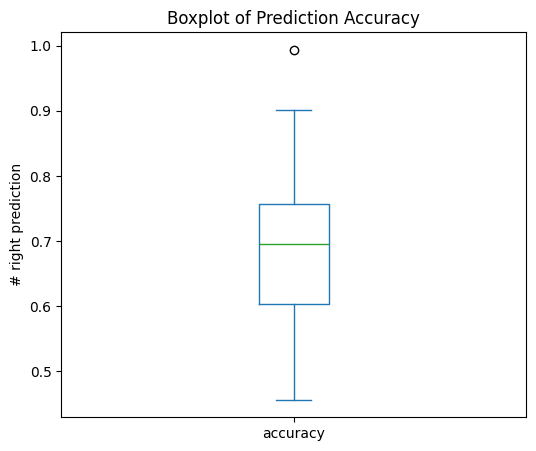

In [16]:
df_maxp["accuracy"].plot(kind='box', figsize=(6, 5))
plt.title("Boxplot of Prediction Accuracy")
plt.ylabel("# right prediction")
plt.show()

In [17]:
df_maxp["correct_heatmaps"].describe()

count    100.000000
mean     342.790000
std       56.720348
min      228.000000
25%      301.500000
50%      347.500000
75%      378.500000
max      497.000000
Name: correct_heatmaps, dtype: float64

### Best predicted Head IDs

In [25]:
# Sort descending:
top_heads = df_maxp.sort_values(by="correct_heatmaps", ascending=False).head(3)
top_heads

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps,accuracy
95,95,500,500,target_met,497,3,0.994
49,49,500,500,target_met,451,49,0.902
60,60,500,500,target_met,451,49,0.902


### worst predicted head IDs

In [29]:
# Sort ascending:
worst_heads = df_maxp.sort_values(by="correct_heatmaps", ascending=True).head(3)
worst_heads

,head_id,collected_heatmaps,target,note,correct_heatmaps,incorrect_heatmaps,accuracy
33,33,500,500,target_met,228,272,0.456
14,14,500,500,target_met,239,261,0.478
18,18,500,500,target_met,241,259,0.482


## Comparison

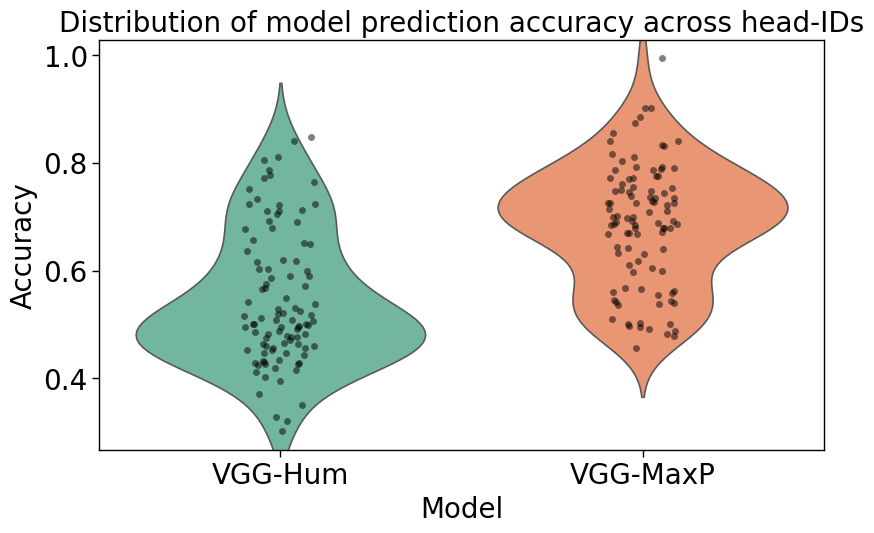

In [ ]:
plt.figure(figsize=(9, 6))

sns.violinplot(x="model", y=col, data=temp, inner=None, palette="Set2")
sns.stripplot(x="model", y=col, data=temp, color="black", alpha=0.5, jitter=True)

plt.title("Distribution of model prediction accuracy across head-IDs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Model", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import shapiro, wilcoxon

# load paired data (same items / heads / images)
m1 = df_hum.sort_values("head_id")
m2 = df_maxp.sort_values("head_id")

x = m1["correct_heatmaps"]
y = m2["correct_heatmaps"]

# 1. normality test (Shapiro–Wilk)
p_x = shapiro(x).pvalue
p_y = shapiro(y).pvalue

print(f"Shapiro–Wilk p-values: model A = {p_x:.4g}, model B = {p_y:.4g}")

Shapiro–Wilk p-values: model A = 0.0005723, model B = 0.05148


-> model A not normally distributed, B is an edge case. So we use Wilcoxon instead of paired t-test

In [ ]:
import numpy as np
from scipy.stats import wilcoxon

stat, p = wilcoxon(x, y)

# number of non-zero differences
n = np.sum((x - y) != 0)

print(f"Wilcoxon signed-rank test:")
print(f"  W statistic = {stat}")
print(f"  n = {n}")
print(f"  p-value = {p:.4g}")

Wilcoxon signed-rank test:
  W statistic = 3.0
  n = 100
  p-value = 4.265e-18
